# Install dependencies

Will require runtime restart to install labelbox and fastai v2 packages

In [ ]:
!pip install labelbox
!pip install Pillow
!pip install fastai --upgrade

We need to determine whether we're running on a Google Colab instance or locally, so we can get data appropriately

In [ ]:
collab_environment = 'google.colab' in str(get_ipython)
if collab_environment:
  print("Running on Google servers")
else:
  import platform
  local_os = platform.system()
  print(f"Running on {local_os}")

Running on Windows


# Decompress source images

We had around 1500 images in our data set, which totals to multiple gigabytes worth of files. To allow cloud access without overflowing our Google Drive storage, we compressed the images into archives and decompress them when the notebook is run.

## Mount Google Drive

In [ ]:
if collab_environment:
  from google.colab import drive
  drive.mount('/content/drive')
  images_archive = '/content/drive/My Drive/480ChevronDrone/image_collection_1-morro_bay.7z'

Mounted at /content/drive


## Install 7zip to decompress image data

In [ ]:
if collab_environment:
  !apt-get install p7zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip is already the newest version (16.02+dfsg-6).
p7zip set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


## Decompress the images to the output Directory

In [ ]:
if collab_environment:
  new_images_archive = '/content/drive/MyDrive/480ChevronDrone/new_data.zip'
  images_output_dir = '/content/training_data/'

  # Extract shallowly (without directory structure) to make finding the files later easier
  # -aos option to automatically skip extracting already extracted images
  !7z e "{images_archive}" -o{images_output_dir} -aos

else:
  images_output_dir = './collab/content/training_data/'

# Get label data from labelbox

## Connect to labelbox

To securely connect to Labelbox, they require an API key. Jupyter notebook has a cool feature to add text-boxes for submitting values, so even though this variable is empty for security, the API key can be added right before runtime.

In [ ]:
import labelbox

#@title Raw fields
labelbox_api_key = ""#@param {type:"string"}
labelbox_client = labelbox.Client(api_key=labelbox_api_key)
labelbox_project = labelbox_client.get_project("ckgsd9vpqcbfi07551i84k16i")
labelbox_dataset = labelbox_client.get_dataset("ckgy008m67eku0784rld6g3lo")

## Convert labels into paths and bounding boxes

We need to take the labels from labelbox and convert them into a format that labelbox will understand. Labelbox has a get_annotations functions that processes COCO JSON files, but it just returns a list of paths to the images and a list of bounding boxes with object names. We can shortcut to this end format using data from labelbox's labels.

Our final result is a dictionary that maps image paths to tuples of bounding boxes and object classes.

In [ ]:
import json
import urllib.request
from PIL import Image
from pathlib import Path

# list of image paths for input into fastai
imgs = []
bbox_classifs = []

# We'll also be creating a dictionary keyed by image path to retrieve bounding
# boxes and classes quickly
img2bbox = {}

for label in labelbox_project.labels():

  # Use the label->dataset relationship to get filename
  image_data = label.data_row()
  file_name = image_data.external_id
  file_path = images_output_dir + file_name

  # If we have the image locally (extracted from archive), don't download it
  if Path(file_path).exists():
    pass
  
  # Otherwise, download the image from labelbox
  # Taken from https://stackoverflow.com/questions/7243750/download-file-from-web-in-python-3
  else:
    print(f"Downloading {file_name}")
    image_url = image_data.row_data
    response = urllib.request.urlretrieve(image_url, file_path)
  
  # get dimensions from image
  #with Image.open(file_path) as image:
  #  image_width, image_height = image.size

  # Actual label data is encoded in a JSON string
  label_data = json.loads(label.label)

  # Access label 'objects' (individual items in an image)
  if "objects" in label_data:

    # Starter tuple for label information
    this_classif = ([], [])

    label_objects = label_data["objects"]

    #print(f"\t{title}: {value}")

    for label_object in label_objects:
      min_x = None
      min_y = None
      max_x = None
      max_y = None

      if "polygon" in label_object:
        object_type = label_object["value"]
        polygon_bounds = label_object["polygon"]

        # Find the bounding box by getting min/max x and y values for the points
        for point in polygon_bounds:
          
          if min_x is None or point["x"] < min_x:
            min_x = point["x"]
          
          if max_x is None or point["x"] > max_x:
            max_x = point["x"]

          if min_y is None or point["y"] < min_y:
            min_y = point["y"]
          
          if max_y is None or point["y"] > max_y:
            max_y = point["y"]
        
        # Add this bounding box (and its classification) to the list of objects
        # for this image
        this_bbox = [int(min_x), int(min_y), int(max_x), int(max_y)]
        this_classif[0].append(this_bbox)
        this_classif[1].append(object_type)

    # Only append to the annotation list if there was at least one object in the image
    # Above fact discovered through painful and extensive trial and error
    if len(this_classif[0]) > 0:
      # Add the image path to the list of images for training
      imgs.append(file_path)

      # Append the bounding box/category tuple to the overall list
      bbox_classifs.append(this_classif)

      # Add the bounding box to the dict for lookup
      img2bbox[file_path] = this_classif

      print(f"{file_name}: {this_classif}")
    
bbox_classifs

# Creating the FastAI Datablock

In [ ]:
from fastai.vision.all import *

Create a dictionary of bounding boxes keyed by the image path

In [ ]:
img2bbox = dict(zip(imgs, bbox_classifs))
img2bbox

FastAI expects three functions that take the path of the image as an input:
1. A function that returns the path of the image (returns itself)
2. A function that gets the bounding box for a given image
3. A function that gets the list of categories for a given image

In [ ]:
def get_image_path(img):
  return img

def get_image_bounding_boxes(img):
  return img2bbox[img][0]

def get_image_classes(img):
  return img2bbox[img][1]

getters = [get_image_path,
           get_image_bounding_boxes,
           get_image_classes]

More data is usually better for training a model. One of the methods FastAI can use to increase the size of the data set is by artificially modifying images in the dataset to produce new images. Many tutorials used functions for rotating, flipping, perspective warping (dihedral), and color modifications. We're going to specifically avoid flipping images, because QR codes with flipped tracking markers are no longer valid QR codes.

Because we're doing transfer learning using imagenet, one of our transforms should be to normalize our data to imagenet's image stats.

There are two types of item transforms: item transforms and batch transforms. [As summarized by Zachary Mueller:](https://forums.fast.ai/t/item-transforms-and-batch-transforms/65506)
> Item transforms are for collating and preparing for a batch and they’re run on the CPU. Batch transforms are applied after everything is resized and batched up and done on the GPU

We ran into issues with GPU memory being exhausted during training, so we are resizing each image to 128x128 pixels for this first model

In [ ]:
item_transforms = [Resize(128, method="crop"),]
batch_transforms = [Normalize.from_stats(*imagenet_stats)]

FastAI is also expecting a separate function to get image paths. We've already defined that in our getters function though, so we'll define a function that ignores the input

In [ ]:
def get_train_imgs(noop):  return imgs

We now create our DataBlock object, which is responsible for getting all of our data in a format that's easy for FastAI to train on, as well as splitting our data into training and validation sets

In [ ]:
pascal_datablock = DataBlock(
    blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
    splitter=RandomSplitter(),
    get_items=get_train_imgs,
    getters=getters,
    item_tfms=item_transforms,
    batch_tfms=batch_transforms,
    n_inp=1)

We can get a summary of the datablock we just created by calling the summary function with the list of images. We found this to be an invaluable tool for bugfixing.

In [ ]:
pascal_datablock.summary(images_output_dir)

In [ ]:
dls = pascal_datablock.dataloaders(images_output_dir)

For our current dataset, we have two classes (`qr_code` and `circular_tag`), so we set the dataloader to expect two classes.

In [ ]:
dls.c = 2

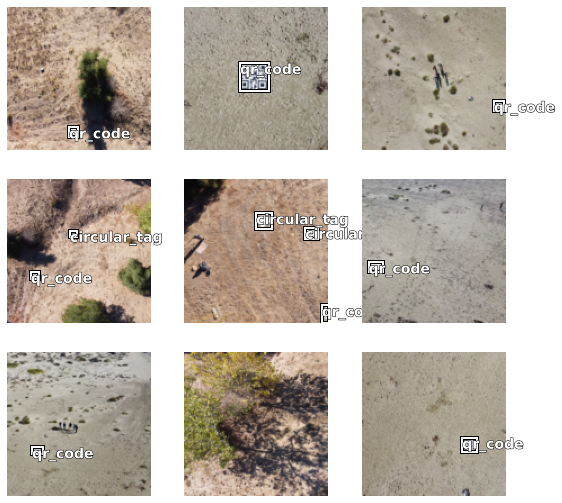

In [ ]:
# shows a test batch of images that go into the model
dls.show_batch()

# Training the model with transfer learning

Clone a repository with helper functions for downloading pretrained models and import its dependencies

In [ ]:
%cd "/content"
!git clone https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0.git
%cd "Practical-Deep-Learning-for-Coders-2.0/Computer Vision"

Cloning into 'Practical-Deep-Learning-for-Coders-2.0'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 1292 (delta 18), reused 26 (delta 6), pack-reused 1227
Receiving objects: 100% (1292/1292), 86.33 MiB | 31.46 MiB/s, done.
Resolving deltas: 100% (805/805), done.
/content/Practical-Deep-Learning-for-Coders-2.0/Computer Vision/Practical-Deep-Learning-for-Coders-2.0/Computer Vision/Practical-Deep-Learning-for-Coders-2.0/Computer Vision


In [ ]:
from imports import *

Download resnet34, and use it to create a new encoder and head for our model

In [ ]:
encoder = create_body(resnet34, pretrained=True)

Now we can actually use RetinaNet. The final bias on the last convolutional layer was taken from the tutorial, but we need to do more research on what that value should be.

In [ ]:
architecture = RetinaNet(encoder, get_c(dls), final_bias=-4)

## Loss function

For the learning process, we need to determine a loss function that allows the model to measure its improvement.

These values were taken straight from a tutorial, but it noted that even they
changed the values from what the original authors of RetinaNet used. We're still determining what the best values for our dataset would be.

In [ ]:
ratios = [1/2,1,2]
scales = [1,2**(-1/3), 2**(-2/3)]

There's a loss function template already created for RetinaNet, which we can use with our modified loss values

In [ ]:
loss_fun = RetinaNetFocalLoss(scales=scales, ratios=ratios)

## Learning

we need to freeze our encoder (the already trained part of the model), but leave everything else unfrozen so it gets updated by the training process.

In [ ]:
# define a function that logically splits the model into its different parts so we can freeze some of them
def _retinanet_split(m): return L(m.encoder,nn.Sequential(m.c5top6, m.p6top7, m.merges, m.smoothers, m.classifier, m.box_regressor)).map(params)

In [ ]:
# Create the new learner object that handles training the new model
learner = Learner(dls, architecture, loss_func=loss_fun, splitter=_retinanet_split)
learner.freeze()

Now all that's left to do is run the training process! As the model runs, it will output statistics on the training loss.

In [ ]:
learner.fit_one_cycle(10, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,time
0,2.075062,2.326584,03:50
1,1.972204,1.744409,03:52
2,1.811052,1.474009,03:55
3,1.688621,1.413728,03:53
4,1.624245,1.503782,03:54
5,1.553451,1.350559,03:51
6,1.482070,1.292228,03:52
7,1.420824,1.282213,03:50
8,1.374031,1.262054,03:53
9,1.332217,1.266762,03:53


Now we can save the model for use in predictions later.

In [ ]:
# Save the model's weights
learner.save(file='/content/drive/MyDrive/480ChevronDrone/models/thefirst')
# Add the Python helper functions used to define data input to the file with weights
learner.export()